## KMeans algorithm
1. initialize k cluster centroids
2. repeat the following:
   - for each point, compute which centroid is nearest to it
   - for each centroid, move its location to the mean location of the points assigned to it

### import libs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# device = torch.device('cpu')
device = torch.device('cuda') # Uncomment this to run on GPU

### generate random data points

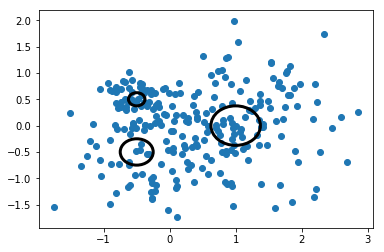

In [3]:
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))

points_th = torch.tensor(points, device=device)

plt.scatter(points[:, 0], points[:, 1])
ax = plt.gca()
ax.add_artist(plt.Circle(np.array([1, 0]), 0.75/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, 0.5]), 0.25/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, -0.5]), 0.5/2, fill=False, lw=3))

### initialize k cluster centroids

In [4]:
def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.clone().detach()
    order = np.array(range(k))
    np.random.shuffle(order)
    # in-place changing of values
    centroids[np.array(range(k))] = centroids[order]
    return centroids[:k]

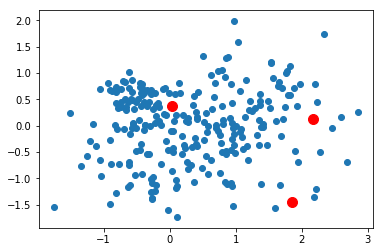

In [5]:
# show initial centroids
plt.scatter(points[:, 0], points[:, 1])
centroids = initialize_centroids(points_th, 3)
centroids_ = centroids.cpu().detach().numpy()
plt.scatter(centroids_[:, 0], centroids_[:, 1], c='r', s=100)

### compute distance for each data points and move centroids

In [6]:
def closest_centroid(points, centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    closest = points.new_zeros((points.size(0)))
    for i in range(points.size(0)):
        distances = torch.sum((points[i] - centroids) ** 2, dim=1)
        closest[i] = torch.argmin(distances)
    return closest
    
def move_centroids(points, closest, centroids):
    """returns the new centroids assigned from the points closest to them"""
    new_centroids = torch.zeros_like(centroids)
    for k in range(centroids.size(0)):
        count = 0
        points_k = torch.zeros_like(points[0])
        for l in range(closest.size(0)):
            if closest[l] == k:
#                 points_k = torch.cat((points_k, points[l]), dim=0)
                points_k += points[l]
                count += 1
        new_centroids[k] = points_k / count
#         new_centroids[k] = torch.mean(points_k, dim=0)
    return new_centroids

[[-0.07857624  0.02718634]
 [ 1.66768344  0.31472332]
 [ 1.16625544 -1.15364362]]


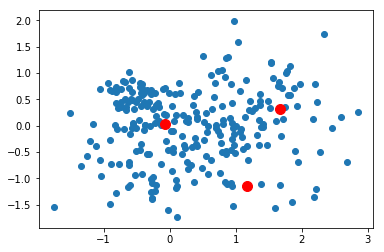

In [7]:
# display one step
closest = closest_centroid(points_th, centroids)
centroids = move_centroids(points_th, closest, centroids)
centroids_ = centroids.cpu().detach().numpy()
print(centroids_)
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids_[:, 0], centroids_[:, 1], c='r', s=100)

### complete kmeans, update centroids in a loop

In [8]:
def kmeans(points, k):
    centroids = initialize_centroids(points, k)
    centroids_old = torch.zeros_like(centroids)
    error = 1e-8
    while torch.norm((centroids - centroids_old)) > error:
        centroids_old = centroids.clone().detach()
        closest = closest_centroid(points, centroids)
        centroids = move_centroids(points, closest, centroids)
    return centroids

[[ 1.39784862  0.43335641]
 [-0.43931252  0.21777931]
 [ 0.44807231 -0.79214377]]


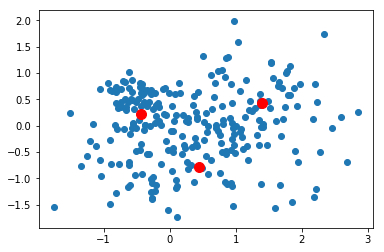

In [9]:
centroids = kmeans(points_th, 3)

# display result
centroids_ = centroids.cpu().detach().numpy()
print(centroids_)
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids_[:, 0], centroids_[:, 1], c='r', s=100)

### compare with sklearn KMeans

[[-0.37576829  0.37638104]
 [ 1.33688465  0.18610102]
 [-0.08720974 -0.84490287]]


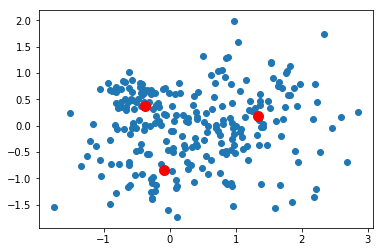

In [10]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(points)
# Getting the cluster labels
labels = kmeans.predict(points)
# Centroid values
centroids = kmeans.cluster_centers_
print(centroids)

# display result
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)